In [1]:
from flask import Flask, request, redirect, url_for,send_from_directory, render_template_string
from werkzeug.utils import secure_filename
import caffe
import json
import numpy as np
import os
from sklearn import svm,metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import struct
import pandas as pd
from __future__ import division
import collections

In [2]:
deployPrototxt = "/opt/swm-ml-docker/swm-ml-master/bvlc_reference_caffenet/deploy.prototxt"
caffeModel = "/opt/swm-ml-docker/swm-ml-master/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel"
featureVectorDirectory = "/opt/swm-ml-docker/data/train"
metadataDirectory = '/opt/swm-ml-docker/metadata_bak/'
imageMeanFile = '/opt/swm-ml-docker/ilsvrc_2012_mean.npy'
layerName = 'fc7'

In [3]:
print("Loading model ...")
cnn = caffe.Net(deployPrototxt, caffe.TEST, weights=caffeModel)
print("Done loading")

Loading model ...
Done loading


In [4]:
# reshape to accept one image at a time.
(_, c, w, h) = cnn.blobs['data'].data.shape
cnn.blobs['data'].reshape(1, c, w, h)
transformer = caffe.io.Transformer({'data': cnn.blobs['data'].data.shape})
transformer.set_mean('data', np.load(imageMeanFile).mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255.0)

In [57]:
def loadMetaData(metadataDir):
    metadataByImageHash = {}
    allFiles = os.listdir(metadataDir)
    for fileName in allFiles:
        with open("%s/%s" % (metadataDir, fileName), "r") as jsonFile:
            metadata = json.load(jsonFile)
            metadataByImageHash[metadata['Image Hash']] = metadata
    return metadataByImageHash

classIdByLabel = {"Dry" : 0, "Wet" : 1, "Reject" : 2, "Garden" : 3}

def makePrimaryLabels(metadataByImageHash, allImageHashes):
    labels = []
    for imageHash in allImageHashes:
        metadata = metadataByImageHash[imageHash]
        labels.append(classIdByLabel[metadata['Primary']])
    return labels

def makeBinaryLabels(metadataByImageHash, allImageHashes):
    labels = []
    for imageHash in allImageHashes:
        metadata = metadataByImageHash[imageHash]
        labels.append(1 if (metadata['Secondary'] == "NA") else 0)
    return labels


def loadFeatureVectors(dirPath,numImages,metadataByImageHash,label,d):
    allFiles = os.listdir(dirPath)
    imageHash=[]
    data = np.zeros([numImages, d])
    idxtoImagehashDict={}
    itr=0
    for i, fileName in enumerate(allFiles):
        with open("%s/%s" % (dirPath, fileName), "rb") as inputFile:
            metadata = metadataByImageHash[fileName]
            if classIdByLabel[metadata['Primary']]==label:
                data[itr] = struct.unpack('f'*d, inputFile.read())
                idxtoImagehashDict[itr]=fileName
                itr+=1
                imageHash.append(fileName)
    return (data,imageHash,idxtoImagehashDict)

In [58]:
metadataByImageHash = loadMetaData(metadataDirectory)
allImageHashes = os.listdir(featureVectorDirectory)
primarylabels = makePrimaryLabels(metadataByImageHash, allImageHashes)
binarylabels= makeBinaryLabels(metadataByImageHash, allImageHashes)
counter=collections.Counter(primarylabels)
data,dryImageHash,idxtoImagehashDict=loadFeatureVectors(featureVectorDirectory,counter[0],metadataByImageHash,0, d = 4096)

In [16]:
dryBinarylabels= makeBinaryLabels(metadataByImageHash, dryImageHash)
print("Training SVM")
clf = svm.SVC(probability=True)
clf.fit(data, dryBinarylabels)
print("Finished training ready to classify images")

Training SVM
Finished training ready to classify images


In [60]:
featureVectorTestDirectory = "/opt/swm-ml-docker/data/test"
allImageHashesTest = os.listdir(featureVectorTestDirectory)
primarylabelsTest = makePrimaryLabels(metadataByImageHash, allImageHashesTest)
counter=collections.Counter(primarylabels)
dataTest,dryImageHashTest,idxtoImagehashDictTest=loadFeatureVectors(featureVectorTestDirectory,counter[0],metadataByImageHash,0, d = 4096)
binarylabelsTest = makeBinaryLabels(metadataByImageHash, dryImageHashTest)

In [32]:
clf.score(dataTest,binarylabelsTest)

0.83673469387755106

In [33]:
prediction=clf.predict(dataTest)

In [34]:
CM = metrics.confusion_matrix(binarylabelsTest,prediction)

In [77]:
print CM

[[49 18]
 [ 6 74]]
Counter({1: 80, 0: 67})


In [36]:
prediction_proba=clf.predict_proba(dataTest)

In [52]:
maxProbaError=[]
for i,p in enumerate(prediction):
    if p==binarylabelsTest[i]:
        pa=prediction_proba[i]
        maxProbaError.append(pa[prediction[i]])
    

In [51]:
print np.mean(maxProbaError)

0.827795088173


# False Negative

6


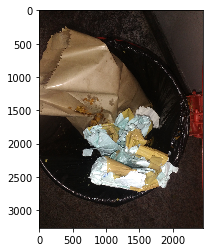

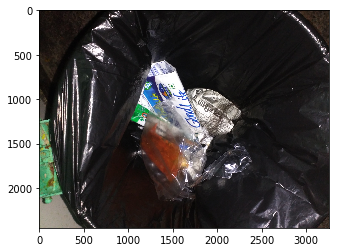

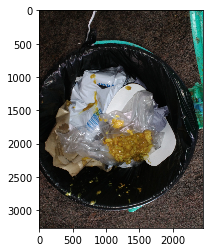

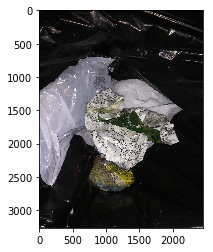

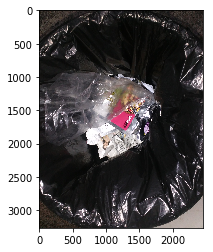

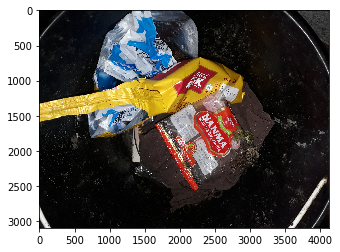

In [72]:
i=0
line_num=[]
while i<len(prediction):
    if prediction[i]==0 and binarylabelsTest[i]==1:
        line_num.append(i)
    i=i+1
    
     
i=0
FNImageHashes=[]

for line in line_num:
       FNImageHashes.append(idxtoImagehashDictTest[line])
 
filepath="/opt/swm-ml-docker/images_bak/"
for i in FNImageHashes:
    s=filepath+i+".jpg"
    img=mpimg.imread(s)
    imgplot = plt.imshow(img)
    plt.show()

In [65]:
imageName=[]
for i in FNImageHashes:
    metadata=metadataByImageHash[i]
    imageName.append(metadata["Image Name"])

df = pd.read_csv('Consolidated.csv')
#data= df.loc[df['Image Name'].isin(imageName)]
data=df[df["Image Name"].isin(imageName) == True]
print len(data)
data.to_csv('FN_exp4_dry_only.csv', sep='\t')

6


# False Positive

18


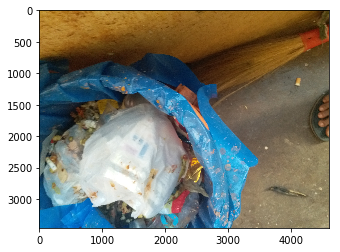

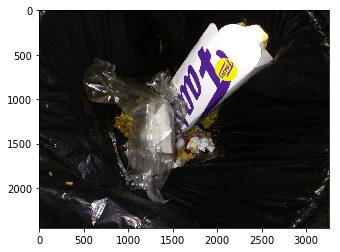

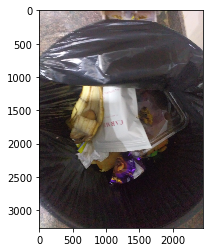

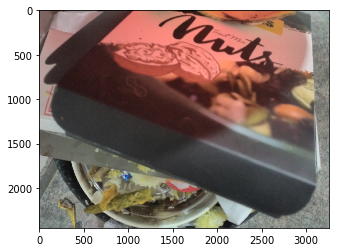

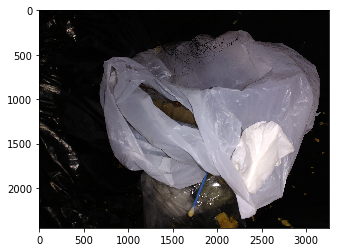

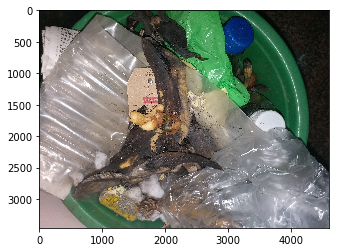

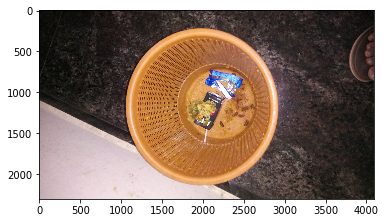

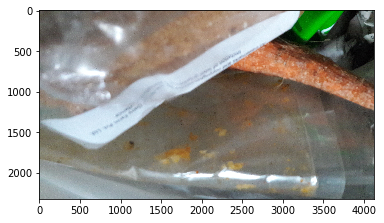

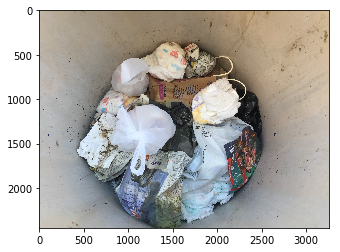

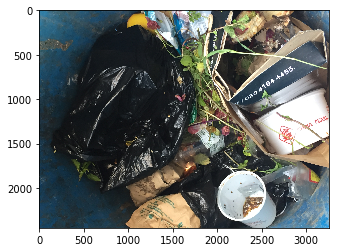

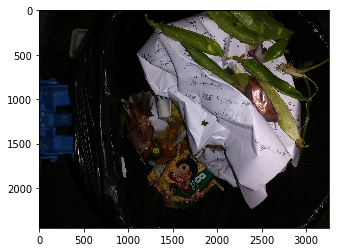

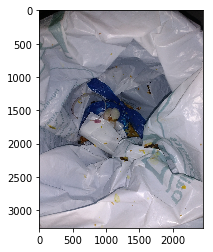

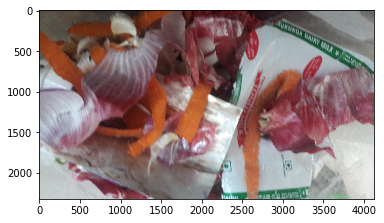

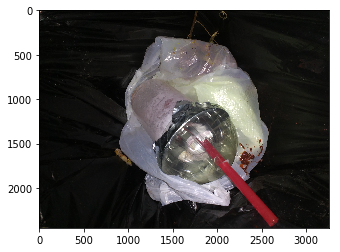

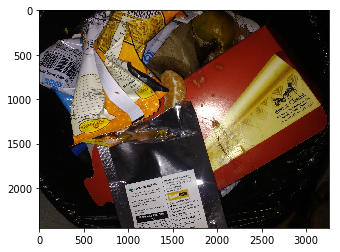

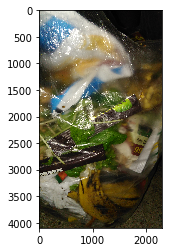

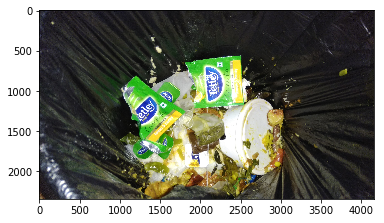

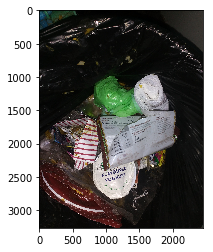

In [73]:
i=0
line_num=[]
while i<len(prediction):
    if prediction[i]==1 and binarylabelsTest[i]==0:
        line_num.append(i)
    i=i+1
     

FPImageHashes=[]

for line in line_num:
    FPImageHashes.append(idxtoImagehashDictTest[line])
    
print len(FPImageHashes)
filepath="/opt/swm-ml-docker/images_bak/"
for i in FPImageHashes:
    s=filepath+i+".jpg"
    img=mpimg.imread(s)
    imgplot = plt.imshow(img)
    plt.show()

In [74]:
imageName=[]
for i in FPImageHashes:
    metadata=metadataByImageHash[i]
    imageName.append(metadata["Image Name"])
    
df = pd.read_csv('Consolidated.csv')
#data= df.loc[df['Image Name'].isin(imageName)]
data=df[df["Image Name"].isin(imageName) == True]
print len(data)
data.to_csv('FP_exp4_dry_only.csv', sep='\t')

16
